# Analysis of Different Feature Groups

Previous experiments told us which metrics were consistently top performing. This notebook exclusively uses those metrics, but varies the included features, performing a permutation test to determine coefficient standard errors

In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from numpy import interp
from pprint import pprint

from numpy.testing import assert_array_equal

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import (
    permutation_importance,
    partial_dependence,
    PartialDependenceDisplay,
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline, Pipeline

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector, heatmap_features
from episcalp.io.read import (
    load_persyst_spikes,
    load_reject_log,
    load_derivative_heatmaps,
    map_rejectlog_to_deriv,
)
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder
from episcalp.cross_validate import exclude_subjects

# if you installed sporf via README
# from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [3]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 1,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

In [4]:
def combine_datasets(deriv_dataset):
    dataset = deriv_dataset[0]
    for deriv in deriv_dataset:
        for key in deriv.keys():
            if key not in dataset.keys():
                raise RuntimeError(
                    f"All keys in {dataset.keys()} must match every other derived dataset. "
                    f"{key}, {deriv.keys()}."
                )

    # convert to a dictionary of lists
    derived_dataset = {key: [] for key in dataset.keys()}
    for deriv in deriv_dataset:
        for key in derived_dataset.keys():
            derived_dataset[key].extend(deriv[key])
    return derived_dataset

# Define Data Directories

In [5]:
user = "patrick"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [6]:
reference = "monopolar"
radius = "1.25"

# define different derivative chains
ss_deriv_chain = Path("sourcesink") / "win-500" / "step-250" / reference
frag_deriv_chain = (
    Path("fragility") / f"radius{radius}" / "win-500" / "step-250" / reference
)

In [7]:
heatmap_reprs = [
    ss_deriv_chain,
    frag_deriv_chain,
]
bids_roots = [jhroot, jeffroot]

In [8]:
if user == "adam":
    deriv_dir = Path(
        "/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives"
    )
elif user == "patrick":
    deriv_dir = Path(
        "D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/derivatives"
    )

# Load the data

In [11]:
# load fragility data
datasets = []
kwargs = {"preload": True}
for root in bids_roots:
    print(f"Loading fragility for {root}")
    dataset = load_derivative_heatmaps(
        root / "derivatives" / frag_deriv_chain,
        search_str="*desc-perturbmatrix*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
        **kwargs
    )
    datasets.append(dataset)
fragility_dataset = combine_datasets(datasets)
print(len(dataset["subject"]))
print(len(fragility_dataset["subject"]))

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Loading fragility for D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh001\sub-jhh001_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh001', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh002\sub-jhh002_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh002', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh003\sub-jhh003_run-01_desc-perturbmatrix_eeg.json
source entities: {'su

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

source entities: {'subject': 'jhh004', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh005\sub-jhh005_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh005', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh006\sub-jhh006_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh006', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\mo

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh008\sub-jhh008_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh008', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh009\sub-jhh009_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh009', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh010\sub-jhh010_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh010', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh012\sub-jhh012_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh012', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh013\sub-jhh013_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh013', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh014\sub-jhh014_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh014', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh017\sub-jhh017_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh017', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh018\sub-jhh018_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh018', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh019\sub-jhh019_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh019', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh022\sub-jhh022_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh022', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh023\sub-jhh023_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh023', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh024\sub-jhh024_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh024', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh027\sub-jhh027_task-awake_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh027', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh028', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh028', 'session': None, 'task': 'aw

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh103\sub-jhh103_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh103', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh104\sub-jhh104_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh104', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh105\sub-jhh105_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh105', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh106\sub-jhh106_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh106', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh107\sub-jhh107_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh107', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh108\sub-jhh108_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh108', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh110\sub-jhh110_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh110', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh111\sub-jhh111_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh111', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh112\sub-jhh112_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh112', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh114\sub-jhh114_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh114', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh115\sub-jhh115_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh115', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh116\sub-jhh116_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh116', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh119\sub-jhh119_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh119', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh120\sub-jhh120_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh120', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh121\sub-jhh121_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh121', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh124', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh125', 'session': None, 'task': 'asleep', 'acquisition': None, 'run': '02', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh125', 'session': None, 'task': 'aw

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh130\sub-jhh130_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh208', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh131\sub-jhh131_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh224', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh201\sub-jhh201_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh201', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh204\sub-jhh204_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh204', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh205\sub-jhh205_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh205', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh206\sub-jhh206_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh206', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh209\sub-jhh209_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh209', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh210\sub-jhh210_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh210', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh211\sub-jhh211_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh211', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh214\sub-jhh214_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh214', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh215\sub-jhh215_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh215', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh216\sub-jhh216_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh216', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh222\sub-jhh222_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh222', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh223\sub-jhh223_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh223', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jhh225\sub-jhh225_run-01_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jhh225', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'pro

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff101\sub-jeff101_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff101', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff101', 'session': '1', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-4_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-6_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '6', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-4_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff203', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff204\sub-jeff204_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff204', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff205', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff206', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff207\sub-jeff207_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff207', 'session': '1', 'task': None, 'acquisition': None

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-2_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff208\sub-jeff208_ses-2_run-4_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff208', 'session': '2', 'task': None, 'acquisition': None, 'run': '4', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff209\sub-jeff209_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff209', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\win-500\step-250\monopolar\sub-jeff210\sub-jeff210_ses-1_run-1_desc-perturbmatrix_eeg.json
source entities: {'subject': 'jeff210', 'session': '1', 'task': None, 'acquisition': None

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

In [12]:
datasets = []
for root in bids_roots:
    dataset = load_derivative_heatmaps(
        root / "derivatives" / ss_deriv_chain,
        search_str="*desc-sinkind*.npy",
        read_func=read_derivative_npy,
        subjects=None,
        verbose=False,
        source_check=False,
    )
    datasets.append(dataset)
sinkind_dataset = combine_datasets(datasets)

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh001\sub-jhh001_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh001', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh002\sub-jhh002_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh002', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh003\sub-jhh003_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh003', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh010\sub-jhh010_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh010', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh011\sub-jhh011_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh011', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh012\sub-jhh012_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh012', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh013\sub-jhh013_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh013', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh019\sub-jhh019_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh019', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh020\sub-jhh020_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh020', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh021\sub-jhh021_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh021', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh022\sub-jhh022_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh022', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
    result = self._run_cell(
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh029', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh030\sub-jhh030_task-awake_run-01_desc-sinkindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

source entities: {'subject': 'jhh030', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh101\sub-jhh101_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh101', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh102\sub-jhh102_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh102', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh103\sub-jhh1

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh109\sub-jhh109_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh109', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh110\sub-jhh110_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh110', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh111\sub-jhh111_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh111', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

source entities: {'subject': 'jhh117', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh118\sub-jhh118_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh118', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh119\sub-jhh119_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh119', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh120\sub-jhh120_

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh125', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh126', 'session': None, 'task': 'awake', 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh127', 'session': None, 'task': 'asleep', 'acquisition': None, 'ru

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh204\sub-jhh204_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh204', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh205\sub-jhh205_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh205', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh206\sub-jhh206_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh206', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh217\sub-jhh217_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh217', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh218\sub-jhh218_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh218', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\win-500\step-250\monopolar\sub-jhh219\sub-jhh219_run-01_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jhh219', 'session': None, 'task': None, 'acquisition': None, 'run': '01', 'processing': None, 'space': None,

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '2', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff102', 'session': '1', 'task': None, 'acquisition': None, 'run': '3', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff102

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '5', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff201\sub-jeff201_ses-1_run-6_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff201', 'session': '1', 'task': None, 'acquisition': None, 'run': '6', 'processing': None, 'space': None, 'recording': None, 'split': None}
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\win-500\step-250\monopolar\sub-jeff202\sub-jeff202_ses-1_run-1_desc-sinkindmatrix_eeg.json
source entities: {'subject': 'jeff202', 'session': '1', 'task': None, 'acquisition': None, 'run': '1', 'processing': No

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

In [13]:
metric_mapping = {
    "fragility": fragility_dataset,
    "sinkind": sinkind_dataset,
}
feature_list = {
    "quantile": ["q0.1", "q0.5", "q0.9", "mean", "std"],
    "lobes": ["frontal-mean", "frontal-std", "temporal-mean", "temporal-std", "occipital-mean", "occipital-std"],
    "distribution": ["entropy", "variance", "skew", "kurtosis", "kldiv"],
}

# Define the experiment - Replicate loop with different feature themes

In [14]:
scaler = StandardScaler()
y_enc = LabelBinarizer()

In [15]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [16]:
stratified_cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)
log_cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

cvs = {
    "stratifiedshuffle": stratified_cv,
    #        "leaveonesubout": log_cv
}

In [35]:
scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": make_scorer(roc_auc_score),
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

scoring = scoring_funcs
print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': make_scorer(roc_auc_score), 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'jaccard': 'jaccard', 'average_precision': 'average_precision', 'neg_brier_score': 'neg_brier_score'}


In [36]:
clf_name = "sporf"
clf_name = "rf"
clf_name = "lr"

In [37]:
metric_dir = "-".join(list(metric_mapping.keys()))
fdir = deriv_dir / "normaleeg" / clf_name / metric_dir
fdir.mkdir(exist_ok=True, parents=True)
fdir
fpath = fdir / "feature_exploration.csv"

In [38]:
pipeline_names = {
    "lr": "logisticregression",
    "rf": "randomforestclassifier",
}

In [39]:
import itertools

dfs = []
idx = 0
for i in range(1, len(feature_list) + 1):
    for names in itertools.combinations(list(feature_list.keys()), i):
        print(f"Looking at features: {names}")
        feat_names = "-".join(names)
        fname = fdir / f"{feat_names}_features.csv"
        # create feature matrix
        features = []
        for idx in range(len(fragility_dataset["subject"])):
            feature_vec = []
            for name in metric_mapping.keys():
                dataset = metric_mapping[name].copy()

                # extract data and form feature vector
                data = dataset["data"][idx]
                ch_names = dataset["ch_names"][idx]
                _feature_vec = heatmap_features(data, ch_names, types=names)
                feature_vec.extend(_feature_vec)
            features.append(feature_vec)

        features = np.array(features)
        print(f"Feature shape: {features.shape}")

        dataset = fragility_dataset

        # get the y-labels
        subjects = np.array(dataset["subject"])
        roots = dataset["roots"]
        
        # get the experimental conditions
        exp_conditions = []
        for subject, root in zip(subjects, roots):
            subj_df = _get_exp_condition(subject, root)
            exp_condition = subj_df["exp_condition"].values[0]
            exp_conditions.append(exp_condition)

        # encode y label
        y = y_enc.fit_transform(exp_conditions)
        y_classes = y_enc.classes_

        X = features
        y = np.array(convert_experimental_cond_to_y(exp_conditions))
        y_classes = y_enc.classes_
        exclusion_criteria = {
            "exp_condition": ["epilepsy-abnormal-eeg"],
            "final_diagnosis": None,
            "epilepsy_type": ["generalized"],
            "epilepsy_hemisphere": None,
            "epilepsy_lobe": None,
        }
        X, y, keep_subjects = exclude_subjects(X, y, subjects, bids_roots, exclusion_criteria)
        print(X.shape, y.shape, keep_subjects.shape)
        max_features = X.shape[1]

        rf_model_params = {
            "n_estimators": 1000,
            "max_features": max_features,
            "n_jobs": -1,
            "random_state": random_state,
        }
        lr_model_params = {
            "n_jobs": -1,
            "random_state": random_state,
            "penalty": "l1",
            "solver": "liblinear",
        }

        if clf_name == "rf":
            clf = RandomForestClassifier(**rf_model_params)
        elif clf_name == "sporf":
            # only used if you installed cysporf
            clf = ObliqueForestClassifier(**rf_model_params)
        elif clf_name == "lr":
            clf = LogisticRegression(**lr_model_params)

        steps = []
        if clf_name == "lr":
            steps.append(StandardScaler())
        steps.append(clf)

        clf = make_pipeline(*steps)

        # fit on entire dataset
        clf.fit(X, y)

        scoring_funcs = {
            "balanced_accuracy": balanced_accuracy_score,
            "cohen_kappa_score": cohen_kappa_score,
            "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
            "f1": f1_score,
            "recall": recall_score,
            "specificity": recall_score,
            "precision": precision_score,
            "jaccard": jaccard_score,
            "average_precision": average_precision_score,
            "neg_brier_score": brier_score_loss,
            "cohen_kappa_score": cohen_kappa_score,
            #     'specificity': '',
        }

        # evaluate the model performance
        train_scores = dict()
        for score_name, score_func in scoring_funcs.items():
            y_pred_proba = clf.predict_proba(X)
            if score_name == "specificity":
                score_func = make_scorer(score_func, pos_label=0)
            else:
                score_func = make_scorer(score_func)
            score = score_func(clf, X, y)

            train_scores[score_name] = score

        for idx in np.unique(y):
            print(f"Class {idx} has ", len(np.argwhere(y == idx)))
        y_pred = clf.predict(X)

        cv_scores = {}
        for cv_name, cv in cvs.items():
            # run cross-validation
            scores = cross_validate(
                clf,
                X,
                y,
                groups=keep_subjects,
                cv=cv,
                scoring=scoring,
                return_estimator=True,
                return_train_score=False,
                n_jobs=-1,
                error_score="raise",
            )

            # get the estimators
            estimators = scores.pop("estimator")
            cv_scores[cv_name] = scores


        result_df = pd.DataFrame()
        idx = 0

        result_df["exp"] = ""
        result_df.at[1, "exp"] = idx
        result_df["heatmaps"] = ""
        result_df.at[1, "heatmaps"] = str(names)
        result_df["data_shape"] = str(X.shape)
        result_df["n_splits"] = n_splits
        result_df["n_classes"] = len(y_enc.classes_)
        result_df["clf"] = clf_name

        for name, score in train_scores.items():
            result_df[f"train_{name}"] = score

        # Get the names of the individual features
        if clf_name == "lr":
            feat_names = ["intercept"]
        else:
            feat_names = []
        top_performers = list(metric_mapping.keys())
        for tp in top_performers:
            for name in names:
                feat_types = feature_list[name]
                names_ = [f"{tp}_{ft}" for ft in feat_types]
                feat_names.extend(names_)
        result_df["feat_names"] = ""
        result_df.at[idx+1, "feat_names"] = feat_names

        print(f"Steps: {clf.named_steps}")
        steps = clf.named_steps
        model = steps[pipeline_names[clf_name]]

        # Grab the coefficients or feature importances depending on the model
        if clf_name == "lr":
            weights = list(model.intercept_)
            weights.extend(model.coef_.tolist()[0])
        else:
            weights = model.feature_importances_
        print(f"Weights: {weights}")
        result_df["weights"] = ""
        result_df.at[idx+1, "weights"] = weights

        for name, scores in cv_scores.items():
            for metric, score in scores.items():
                if not metric.startswith("test_"):
                    continue

                result_df[f"{name}_{metric}"] = ""
                result_df.at[1, f"{name}_{metric}"] = score
                result_df[f"{name}_{metric}_avg"] = np.mean(score)
                result_df[f"{name}_{metric}_std"] = np.std(score)
        dfs.append(result_df)

result_df = pd.concat(dfs)
    
result_df.to_csv(fpath, index=None)

Looking at features: ('quantile',)
Feature shape: (125, 10)
(73, 10) (73,) (73,)
Class 0 has  35
Class 1 has  38
Steps: {'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                   solver='liblinear')}
Weights: [0.03816176839816254, 0.5588611532407106, 0.0, -0.2818873670295672, 0.2078014020208549, 0.0, 0.0820567083614851, 0.0, 0.2453127292067591, -0.011886098778253772, 0.0]
Looking at features: ('lobes',)
Feature shape: (125, 12)
(73, 12) (73,) (73,)
Class 0 has  35
Class 1 has  38
Steps: {'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(n_jobs=-1, penalty='l1', random_state=12345,
                   solver='liblinear')}
Weights: [0.030497928822369055, 0.32965546882719854, -0.3549862209557735, 0.11072164709217093, -0.09276313189763946, 0.0, 0.18473557749529942, -0.6057126424809776, -0.14678742003095982, -0.40987571706555886, -0.06010804887527858, 0.0, 0.0]
Looking at features: (

# Read in results and plot coefficients/feature importances

In [40]:
import ast
result_df = pd.read_csv(fpath)
feat_names = result_df["feat_names"]
feat_weights = result_df["weights"]
train_aucs = result_df["train_roc_auc"]
feat_list = []
weight_list = []
for idx, fn in feat_names.items():
    feat_list.append(ast.literal_eval(fn))
for idx, fw in feat_weights.items():
    fw = " ".join(fw.split()).replace("[[ ", "[").replace(" ]]", "]").replace("]]", "]")
    weight_list.append(ast.literal_eval(fw))    

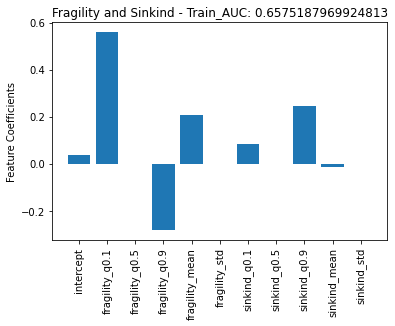

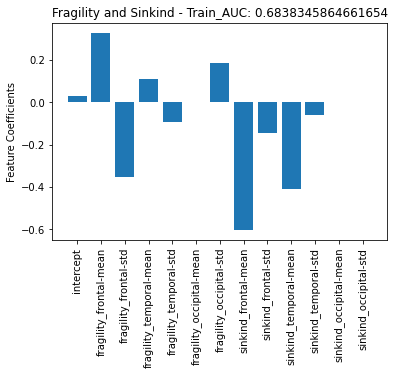

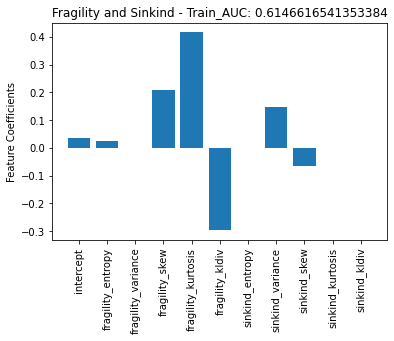

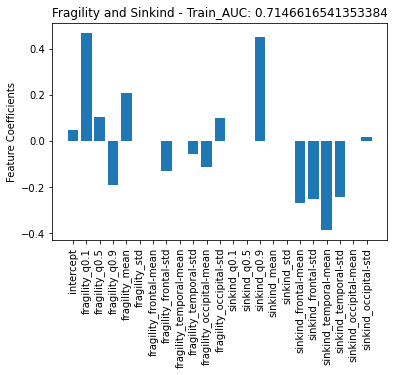

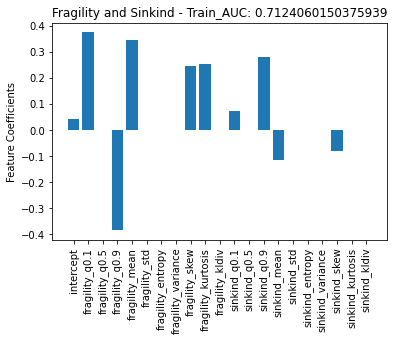

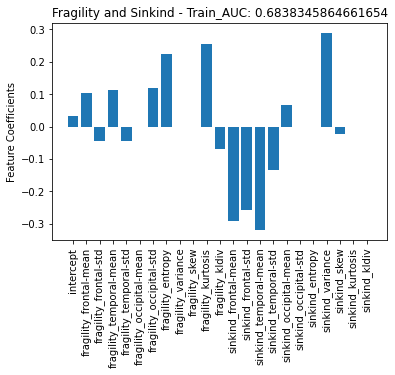

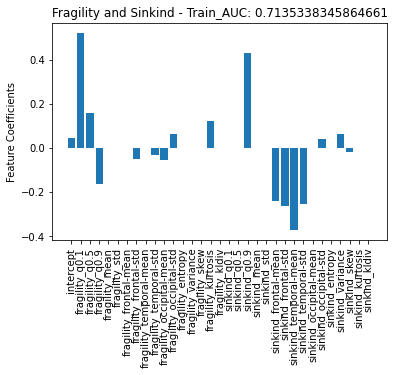

In [41]:
for exp in range(len(feat_list)):
    feature_names = feat_list[exp]
    weights = weight_list[exp]
    auc = train_aucs[exp]
    fig, ax = plt.subplots()
    xs = np.arange(0, len(weights))
    ax.bar(xs, weights)
    ax.set_xticks(xs)
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_ylabel('Feature Coefficients')
    ax.set_title(f"Fragility and Sinkind - Train_AUC: {auc}")

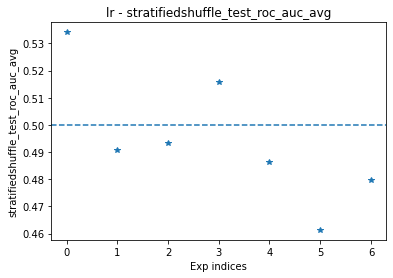

In [43]:
fig, ax = plt.subplots()

y = "stratifiedshuffle_test_roc_auc_avg"
aucs = result_df[y]
ax.plot(aucs, "*")
ax.set(title=f"{clf_name} - {y}", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

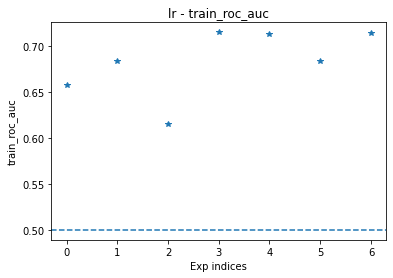

In [44]:
fig, ax = plt.subplots()

y = "train_roc_auc"
ax.plot(result_df[y], "*")
ax.set(title=f"{clf_name} - {y}", xlabel="Exp indices", ylabel=y)
ax.axhline([0.5], ls="--")

# Run Permutation Importances for Each Model

In [46]:
cv_model = None
cv_model = "stratifiedshuffle"

In [47]:
scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_score,
    "cohen_kappa_score": cohen_kappa_score,
    "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
    "f1": f1_score,
    "recall": recall_score,
    "specificity": recall_score,
    "precision": precision_score,
    "jaccard": jaccard_score,
    "average_precision": average_precision_score,
    "neg_brier_score": brier_score_loss,
    "cohen_kappa_score": cohen_kappa_score,
    #     'specificity': '',
}

In [48]:
clf_name = "lr"
metric_set = "fragility-sinkind"
exhaustive_fpath = deriv_dir / "normaleeg" / clf_name / metric_set / f"feature_exploration.csv"
exhaustive_df = pd.read_csv(exhaustive_fpath, index_col=None)

print(exhaustive_df.shape)
display(exhaustive_df.head())

(7, 45)


,exp,heatmaps,data_shape,n_splits,n_classes,clf,train_balanced_accuracy,train_cohen_kappa_score,train_roc_auc,train_f1,...,stratifiedshuffle_test_precision_std,stratifiedshuffle_test_jaccard,stratifiedshuffle_test_jaccard_avg,stratifiedshuffle_test_jaccard_std,stratifiedshuffle_test_average_precision,stratifiedshuffle_test_average_precision_avg,stratifiedshuffle_test_average_precision_std,stratifiedshuffle_test_neg_brier_score,stratifiedshuffle_test_neg_brier_score_avg,stratifiedshuffle_test_neg_brier_score_std
0,0,"('quantile',)","(73, 10)",20,3,lr,0.657519,0.314683,0.657519,0.666667,...,0.085485,[0.33333333 0.41176471 0.35294118 0.4 0...,0.383860,0.106510,[0.56448653 0.65360397 0.64976791 0.68991463 0...,0.621891,0.083566,[-0.316293 -0.23211853 -0.28448126 -0.236353...,-0.271329,0.041647
1,0,"('lobes',)","(73, 12)",20,3,lr,0.683835,0.368084,0.683835,0.701299,...,0.102663,[0.41176471 0.21052632 0.3125 0.41176471 0...,0.332317,0.099467,[0.57861579 0.46730502 0.56575811 0.63834923 0...,0.582781,0.075690,[-0.28463404 -0.41619414 -0.27879152 -0.255793...,-0.292769,0.054452
2,0,"('distribution',)","(73, 10)",20,3,lr,0.614662,0.229842,0.614662,0.641026,...,0.080959,[0.26315789 0.4 0.29411765 0.44444444 0...,0.353850,0.099063,[0.56066682 0.51911199 0.62034485 0.64112979 0...,0.598946,0.094266,[-0.29291498 -0.2706943 -0.27938745 -0.240007...,-0.274401,0.040761
3,0,"('quantile', 'lobes')","(73, 22)",20,3,lr,0.714662,0.426916,0.714662,0.704225,...,0.093429,[0.4375 0.22222222 0.375 0.4375 0...,0.355649,0.099549,[0.58210678 0.46081151 0.70349503 0.66006085 0...,0.590497,0.093509,[-0.30419992 -0.41471888 -0.2753601 -0.250633...,-0.310829,0.060798
4,0,"('quantile', 'distribution')","(73, 20)",20,3,lr,0.712406,0.424333,0.712406,0.720000,...,0.068739,[0.31578947 0.4 0.35294118 0.27777778 0...,0.346902,0.078947,[0.59290865 0.48509176 0.60101839 0.57139952 0...,0.571424,0.079010,[-0.31705234 -0.28353523 -0.28529928 -0.247513...,-0.293539,0.044968


In [49]:
def bootstrap_clf_importances(
    clf, X, y, clf_model, n_boot_samples=50, random_state=None
):
    # bootstrap sample
    from sklearn.utils import resample

    n_samples, n_features = X.shape
    bootstrap_weights = np.zeros((n_boot_samples, n_features))

    for idx in range(n_boot_samples):
        X_boot, y_boot = resample(
            X,
            y,
            replace=True,
            n_samples=n_samples,
            stratify=y,
            random_state=random_state,
        )

        # fit the classifier model
        clf.fit(X_boot, y_boot)

        # get the weights/importances
        if clf_model == "lr":
            weights_ = clf.named_steps["clf"].coef_
        elif clf_model in ["rf", "sporf"]:
            weights_ = clf.named_steps["clf"].feature_importances_
        bootstrap_weights[idx, :] = weights_

    return bootstrap_weights

In [50]:
total_X = []
total_feat_names = []
total_feat_set = []
idx = 0
for i in range(1, len(feature_list) + 1):
    for names in itertools.combinations(list(feature_list.keys()), i):
        #print(f"Looking at features: {names}")
        total_feat_set.append(names)
        feat_names = "-".join(names)
        fname = fdir / f"{feat_names}_features.csv"
        # create feature matrix
        features = []
        for idx in range(len(fragility_dataset["subject"])):
            feature_vec = []
            for name in metric_mapping.keys():
                dataset = metric_mapping[name].copy()

                # extract data and form feature vector
                data = dataset["data"][idx]
                ch_names = dataset["ch_names"][idx]
                _feature_vec = heatmap_features(data, ch_names, types=names)
                feature_vec.extend(_feature_vec)
            features.append(feature_vec)

        features = np.array(features)
        #print(f"Feature shape: {features.shape}")

        dataset = fragility_dataset

        # get the y-labels
        subjects = np.array(dataset["subject"])
        roots = dataset["roots"]
        
        # get the experimental conditions
        exp_conditions = []
        for subject, root in zip(subjects, roots):
            subj_df = _get_exp_condition(subject, root)
            exp_condition = subj_df["exp_condition"].values[0]
            exp_conditions.append(exp_condition)

        # encode y label
        y = y_enc.fit_transform(exp_conditions)
        y_classes = y_enc.classes_

        X = features
        y = np.array(convert_experimental_cond_to_y(exp_conditions))
        y_classes = y_enc.classes_
        exclusion_criteria = {
            "exp_condition": ["epilepsy-abnormal-eeg"],
            "final_diagnosis": None,
            "epilepsy_type": ["generalized"],
            "epilepsy_hemisphere": None,
            "epilepsy_lobe": None,
        }
        X, y, keep_subjects = exclude_subjects(
            X, y, subjects, bids_roots, exclusion_criteria
        )
        max_features = X.shape[1]

        total_X.append(X)
        
        feat_names= []
        top_performers = list(metric_mapping.keys())
        for tp in top_performers:
            for name in names:
                feat_types = feature_list[name]
                names_ = [f"{tp}_{ft}" for ft in feat_types]
                feat_names.extend(names_)
        total_feat_names.append(feat_names)

print([x.shape for x in total_X])
print([len(f) for f in total_feat_names])
print(y.shape)
print([len(fs) for fs in total_feat_set])

[(73, 10), (73, 12), (73, 10), (73, 22), (73, 20), (73, 22), (73, 32)]
[10, 12, 10, 22, 20, 22, 32]
(73,)
[1, 1, 1, 2, 2, 2, 3]


(10, 50)
(12, 50)
(10, 50)
(22, 50)
(20, 50)
(22, 50)
(32, 50)


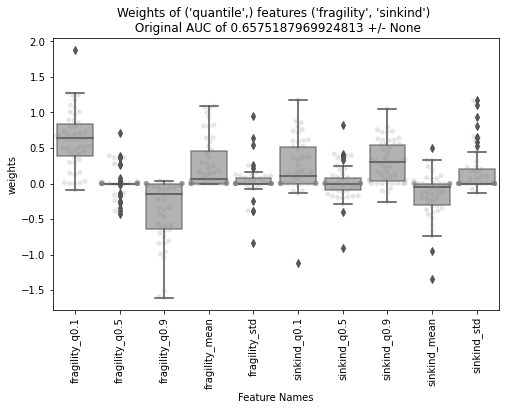

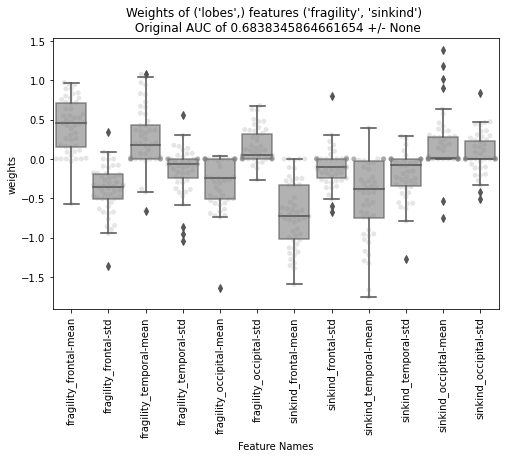

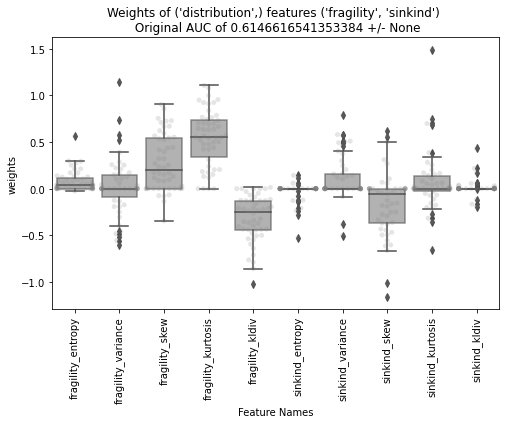

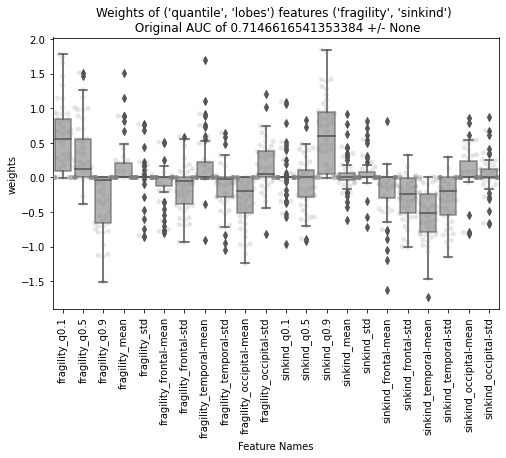

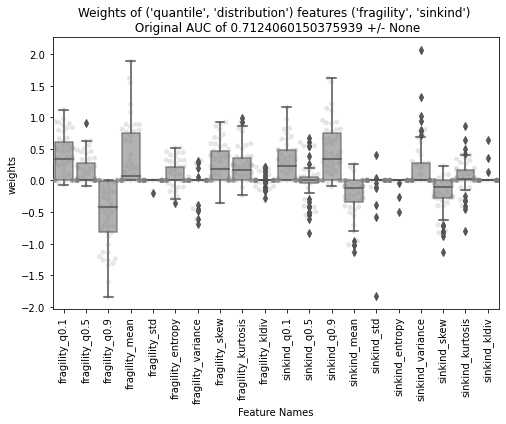

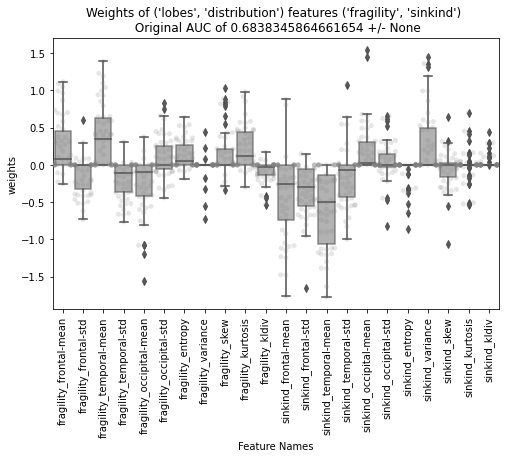

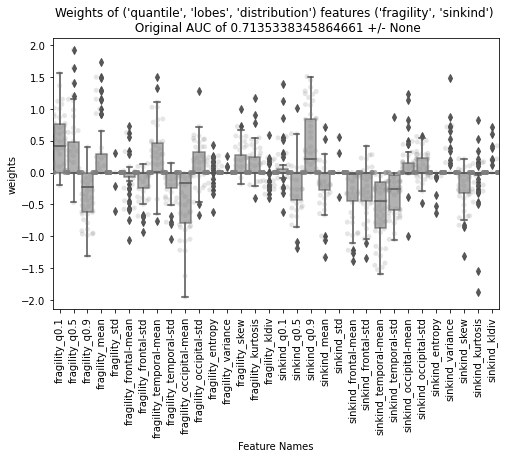

In [51]:
for X, feature_names, feat_set in zip(total_X, total_feat_names, total_feat_set):
    # create the classification model
    max_features = X.shape[1]
    rf_model_params = {
        "n_estimators": 1000,
        "max_features": max_features,
        "n_jobs": -1,
        "random_state": random_state,
    }

    if clf_name == "rf":
        clf = RandomForestClassifier(**rf_model_params)
    elif clf_name == "sporf":
        # only used if you installed cysporf
        clf = ObliqueForestClassifier(**rf_model_params)
    elif clf_name == "lr":
        clf = LogisticRegression(**lr_model_params)

    steps = []
    if clf_name == "lr":
        steps.append(("scalar", StandardScaler()))
    steps.append(("clf", clf))

    clf = Pipeline(steps)

    clf.fit(X, y)
    #y_predict_proba = clf.predict_proba(X)[:, 1]
    score_func = make_scorer(roc_auc_score)
    auc_score = score_func(clf, X, y)
    #auc_score = roc_auc_score(y, y_predict_proba)
    auc_score_std = None

    # run bootstrap on dataset
    weights = bootstrap_clf_importances(
        clf, X, y, clf_model=clf_name, n_boot_samples=50, random_state=None
    )

    df = pd.DataFrame(weights).T
    print(df.shape)
    df["names"] = feature_names
    df = pd.melt(
        df,
        id_vars="names",
        #         value_vars=np.arange(0, 30),
        value_name="weights",
        var_name="repeat_num",
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.swarmplot(x="names", y="weights", data=df, ax=ax, color="gray", alpha=0.2)
    sns.boxplot(
        x="names",
        y="weights",
        data=df,
        ax=ax,
        color="gray",
        boxprops=dict(alpha=0.6),
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(
        xlabel="Feature Names",
        title=f"Weights of {feat_set} features ('fragility', 'sinkind') \n "
        f"Original AUC of {auc_score} +/- {auc_score_std}",
    )

    #break